# Adult Income Prediction Dataset - Proyecto Final

Luciana Hoyos Pérez, Juan José Gómez Vélez y Santiago Manco Maya

## 1. Análisis Preliminar del Problema

Este dataset corresponde a un problema de clasificación, ya que la variable objetivo (target) income indica si un adulto gana más o menos de 50k dólares al año. Es decir, el modelo debe aprender a clasificar a los individuos en dos categorías: altos salarios y bajos salarios. Por lo tanto, no se busca predecir un valor numérico continuo (como en regresión), sino asignar cada observación a una clase definida.



In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

from imblearn.over_sampling import SMOTENC

# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras import regularizers

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    PolynomialFeatures,
    FunctionTransformer,
)

datos = pd.read_csv("adult.csv")

datos.info()

# Diccionario para clasificar variables
tipos_variables = {
    "numéricas": [],
    "categóricas": [],
    "binarias": [],
    "ordinales": []
}

for col in datos.columns:

    if pd.api.types.is_numeric_dtype(datos[col]):

        if datos[col].nunique() == 2:
            tipos_variables["binarias"].append(col)
        else:
            tipos_variables["numéricas"].append(col)

    else:

        if datos[col].nunique() == 2:
            tipos_variables["binarias"].append(col)
        else:
            tipos_variables["categóricas"].append(col)

tipos_variables["ordinales"] = ["EducationalLevel"]

# Mostrar resultado
for tipo, columnas in tipos_variables.items():
    print(f"\n{tipo.upper()}:")
    for c in columnas:
        print(f" - {c}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education.num   32561 non-null  int64 
 5   marital.status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital.gain    32561 non-null  int64 
 11  capital.loss    32561 non-null  int64 
 12  hours.per.week  32561 non-null  int64 
 13  native.country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB

NUMÉRICAS:
 - age
 - fnlwgt
 - education.num
 - capital.gain
 - capital.loss
 - hours.per.we

Ese dataset proviene originalmente del UCI Machine Learning Repository, bajo el nombre Adult o Census Income dataset.

Más específicamente:

- Los datos provienen del Censo de los EE. UU. de 1994.
- Fueron extraídos por Barry Becker (y otros colaboradores) a partir de registros del censo, aplicando ciertos filtros (por ejemplo: edad >16, horas de trabajo >0, etc.).
- El objetivo original fue generar un conjunto de registros “limpios” para predicción: determinar si el ingreso de una persona excede los $50,000 anuales.

## 2. Análisis exploratorio de datos (EDA) y Limpieza

In [2]:
# Distribución de cada variable

for col in datos.columns:
    print(f"\nDistribución de {col}")
    print(datos[col].value_counts(dropna=False))


Distribución de age
age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: count, Length: 73, dtype: int64

Distribución de workclass
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: count, dtype: int64

Distribución de fnlwgt
fnlwgt
123011    13
203488    13
164190    13
126675    12
121124    12
          ..
222966     1
301229     1
155382     1
268083     1
113987     1
Name: count, Length: 21648, dtype: int64

Distribución de education
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate     

In [3]:
# Reemplazar " ?" y espacios vacíos por NaN y eliminar filas con valores faltantes
datos = datos.replace('?', pd.NA)
datos = datos.replace(r'^\s*$', pd.NA, regex=True)
datos = datos.dropna()

cat_cols = datos.select_dtypes(include=['object']).columns
num_cols = datos.select_dtypes(exclude=['object']).columns

# Mostrar resultado final
print("\nLimpieza completa.")
print(f"Filas finales: {len(datos)}")
print(f"Columnas finales: {len(datos.columns)}")
print("\nPrimeras filas del dataset transformado:")
print(datos.head())


Limpieza completa.
Filas finales: 30162
Columnas finales: 15

Primeras filas del dataset transformado:
   age workclass  fnlwgt     education  education.num marital.status  \
1   82   Private  132870       HS-grad              9        Widowed   
3   54   Private  140359       7th-8th              4       Divorced   
4   41   Private  264663  Some-college             10      Separated   
5   34   Private  216864       HS-grad              9       Divorced   
6   38   Private  150601          10th              6      Separated   

          occupation   relationship   race     sex  capital.gain  \
1    Exec-managerial  Not-in-family  White  Female             0   
3  Machine-op-inspct      Unmarried  White  Female             0   
4     Prof-specialty      Own-child  White  Female             0   
5      Other-service      Unmarried  White  Female             0   
6       Adm-clerical      Unmarried  White    Male             0   

   capital.loss  hours.per.week native.country income 

**Nota:** Gracias a la anterior limpieza se pudieron eliminar alrededor de 5000 datos que generaban ruido y/o fugas de información.

In [4]:
# Codificar categóricas (One-Hot Encoding)

datos_cod = pd.get_dummies(datos, drop_first=True)

# Buscar la variable objetivo codificada (>50K o <=50K)
target_col = [c for c in datos_cod.columns if 'income' in c.lower()][0]

# Calcular correlación con la variable objetivo
correlaciones_objetivo = datos_cod.corr()[target_col].sort_values(ascending=False)

print("\nCorrelación de todas las variables con la variable objetivo:")
print(correlaciones_objetivo)


Correlación de todas las variables con la variable objetivo:
income_>50K                          1.000000
marital.status_Married-civ-spouse    0.445418
education.num                        0.335286
age                                  0.241998
hours.per.week                       0.229480
                                       ...   
relationship_Unmarried              -0.145799
occupation_Other-service            -0.165934
relationship_Not-in-family          -0.193258
relationship_Own-child              -0.226186
marital.status_Never-married        -0.320053
Name: income_>50K, Length: 97, dtype: float64


**Nota:** Las variables binarias, en el caso de este hot encoder que usamos para el análisis, omiten una de las opciones. Por ejemplo, en el caso de *sex* se usa *sex_Male*, si es 1, es hombre, y si es 0, es mujer.

In [5]:
# Correlaciones más altas y más bajas
print("\n🔝 Variables con mayor correlación positiva con la variable objetivo:")
print(correlaciones_objetivo.head(10))

print("\n🔚 Variables con mayor correlación negativa con la variable objetivo:")
print(correlaciones_objetivo.tail(10))


🔝 Variables con mayor correlación positiva con la variable objetivo:
income_>50K                          1.000000
marital.status_Married-civ-spouse    0.445418
education.num                        0.335286
age                                  0.241998
hours.per.week                       0.229480
capital.gain                         0.221196
sex_Male                             0.216699
occupation_Exec-managerial           0.213442
occupation_Prof-specialty            0.181458
education_Bachelors                  0.178847
Name: income_>50K, dtype: float64

🔚 Variables con mayor correlación negativa con la variable objetivo:
education_11th                 -0.084522
race_Black                     -0.088332
occupation_Handlers-cleaners   -0.093836
workclass_Private              -0.117218
education_HS-grad              -0.136137
relationship_Unmarried         -0.145799
occupation_Other-service       -0.165934
relationship_Not-in-family     -0.193258
relationship_Own-child         -0.2261

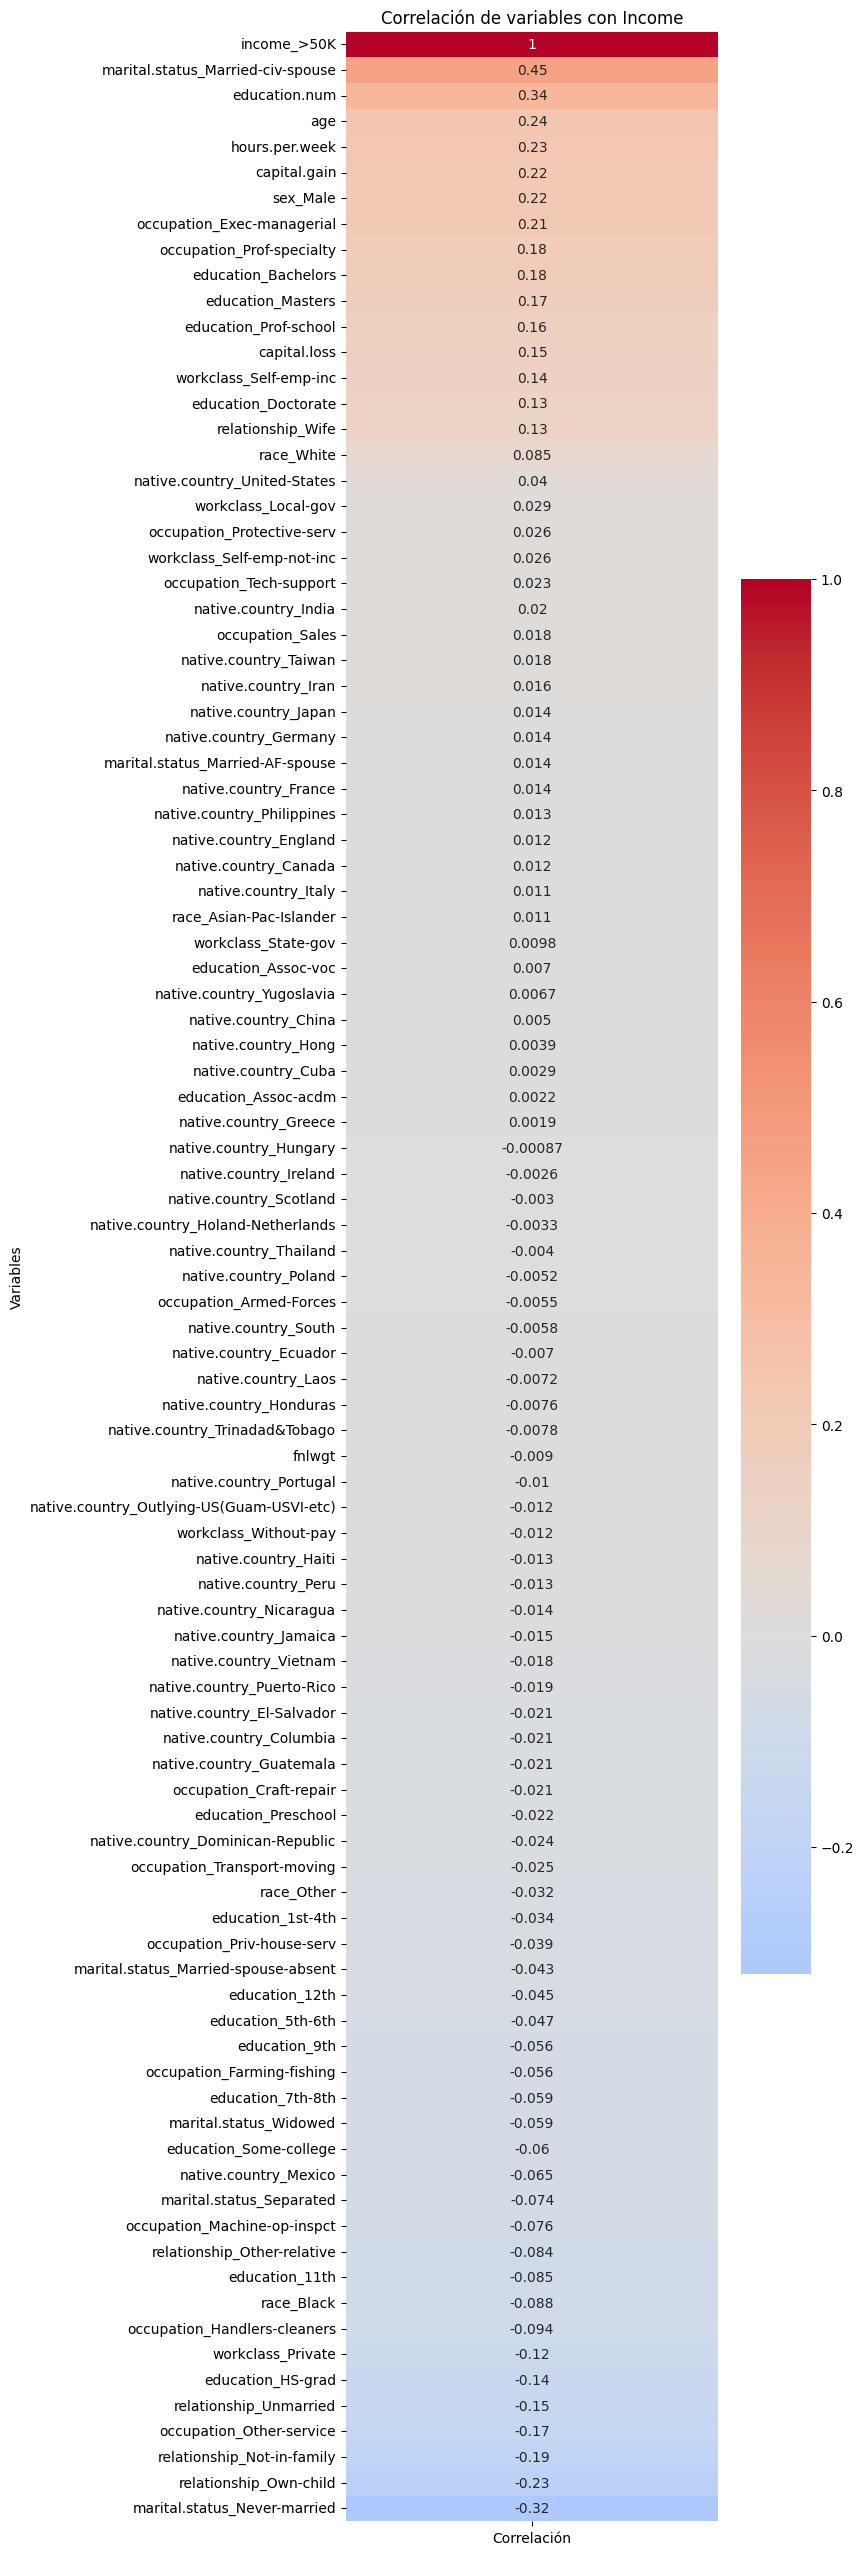

In [6]:
# Diagrama de calor de correlaciones con la variable objetivo

# Crear DataFrame para visualización
corr_target_df = correlaciones_objetivo.to_frame(name="Correlación")

# --- Graficar heatmap solo con las correlaciones respecto a income ---
plt.figure(figsize=(6, len(corr_target_df) / 3))  # tamaño dinámico según número de variables
sns.heatmap(corr_target_df, annot=True, cmap="coolwarm", center=0)
plt.title("Correlación de variables con Income")
plt.ylabel("Variables")
plt.show()


**Análisis de Correlaciones:**

En la presente correlación se analizaron las variables en términos de qué correlación tienen cuando income es mayor a 50k dólares. Lo anterior arrojó los siguientes resultados:

- Estar casado, tener un buen nivel de educación, trabajar varias horas a la semana, tener una mayor edad, ser hombre, haber nacido en EEUU, tener una buena ocupación y ser blanco son factores importantes, según este dataset y el análisis arrojado, para obtener mayores ingresos. Esto puede explicarse porque las personas casadas suelen gozar de mayor estabilidad económica y motivación familiar, lo que impulsa su desarrollo profesional. Un nivel educativo alto abre oportunidades en empleos calificados y mejor pagados, mientras que una mayor edad refleja experiencia y seniority en el mercado laboral. Ser hombre aparece correlacionado positivamente debido a desigualdades estructurales históricas de género que aún persisten en los ingresos. Asimismo, nacer en Estados Unidos facilita el acceso a mejores condiciones laborales y evita las barreras legales o culturales que enfrentan los inmigrantes. Finalmente, ocupar puestos técnicos o administrativos, y pertenecer al grupo racial blanco, son variables que, en el contexto del mercado estadounidense y sus inequidades históricas, tienden a asociarse con mayores ingresos.

- Las variables que no importan mucho en la decisión sería el haber nacido en países como Trinidad u Honduras, el final weight y trabajos no pagos. Estas variables presentan correlaciones débiles o casi nulas debido a su bajo peso estadístico o su naturaleza no explicativa. En el caso de los países de origen con poca representación, la escasez de datos impide detectar relaciones sólidas con los ingresos. El atributo final weight (fnlwgt) es un valor técnico usado por el censo para ponderar observaciones, por lo que no tiene impacto directo sobre el salario. Finalmente, las categorías de trabajos sin remuneración carecen de relevancia predictiva porque representan muy pocos casos y no reflejan un empleo formal que genere ingresos anuales.

- Las variables que afectan negativamente a los ingresos son: el no haberse casado o no tener familia, tener un bajo nivel de educación, tener una ocupación humilde, ser mujer (por el complemento de *sex_Male*) y ser de raza negra. En términos socioeconómicos, estas correlaciones negativas pueden atribuirse a desigualdades estructurales. Las personas solteras o sin familia tienden a tener menor estabilidad o motivación económica, lo que puede reflejarse en menores ingresos. Los niveles educativos bajos limitan el acceso a trabajos de mayor remuneración y proyección profesional. Ocupaciones consideradas “modestas” o manuales suelen ofrecer salarios más bajos y menos beneficios. Las mujeres muestran una tendencia opuesta a sex_Male, evidenciando brechas salariales de género persistentes. Por último, la menor correlación de las personas identificadas como negras con ingresos altos refleja las desigualdades históricas de acceso a educación, empleo y oportunidades que aún persisten en el mercado laboral estadounidense.

In [7]:
# Separar variables predictoras (X) y target (y)
X = datos.drop(columns=["income", "fnlwgt"]) # fnlwgt no es predictora relevante
y = datos["income"]

# Dividir datos en entrenamiento, prueba y validación
# Primero 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Luego dividir temp en val (15%) y test (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print(f"Tamaño de X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Tamaño de X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Tamaño de X_test: {X_test.shape}, y_test: {y_test.shape}")


Tamaño de X_train: (21113, 13), y_train: (21113,)
Tamaño de X_val: (4524, 13), y_val: (4524,)
Tamaño de X_test: (4525, 13), y_test: (4525,)


In [ ]:
# Balancear SOLO el conjunto de entrenamiento (undersampling)

print("\nDistribución original en y_train:")
print(y_train.value_counts())

# 1️⃣ Detectar automáticamente las columnas categóricas
columnas_categoricas = X_train.select_dtypes(include=["object", "category"]).columns

# 2️⃣ Obtener los índices de esas columnas
cat_features = [X_train.columns.get_loc(col) for col in columnas_categoricas]

print("Columnas categóricas detectadas:", list(columnas_categoricas))
print("Índices categóricos:", cat_features)

# 3️⃣ Crear y aplicar SMOTENC
smote_nc = SMOTENC(categorical_features=cat_features, random_state=43)

X_train_res, y_train_res = smote_nc.fit_resample(X_train, y_train)

print("Tamaño original:", X_train.shape, "→ Rebalanceado:", X_train_res.shape)

# ===============================
# Verificación del balanceo
# ===============================

print("\nDistribución balanceada en y_train_bal:")
print(y_train_res.value_counts())
print(f"\nTamaño final X_train_bal: {X_train_res.shape}, y_train_bal: {y_train_res.shape}")


Distribución original en y_train:
income
<=50K    15857
>50K      5256
Name: count, dtype: int64
Columnas categóricas detectadas: ['workclass', 'education', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country']
Índices categóricos: [1, 2, 4, 5, 6, 7, 8, 12]
Tamaño original: (21113, 13) → Rebalanceado: (31714, 13)

Distribución balanceada en y_train_bal:
income
<=50K    15857
>50K     15857
Name: count, dtype: int64

Tamaño final X_train_bal: (31714, 13), y_train_bal: (31714,)



Entrenando Random Forest...

Entrenando Gradient Boosting...

Mejores hiperparámetros (Random Forest): {'classifier__max_depth': 9, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 200}
Mejores hiperparámetros (Gradient Boosting): {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__n_estimators': 200}

Resultados finales:
              Modelo     Dataset  Accuracy  F1 Score
0      Random Forest       Train  0.843823  0.842846
1      Random Forest  Validation  0.792219  0.762344
2      Random Forest        Test  0.795580  0.765782
3  Gradient Boosting       Train  0.933815  0.933765
4  Gradient Boosting  Validation  0.850354  0.812487
5  Gradient Boosting        Test  0.844641  0.803725


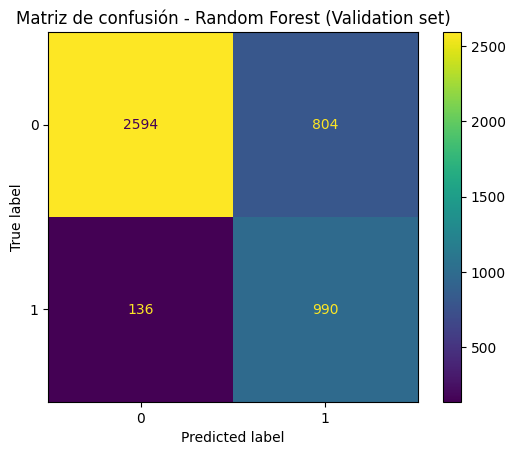

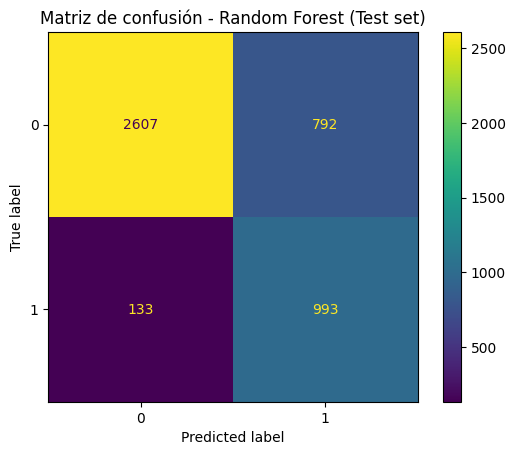

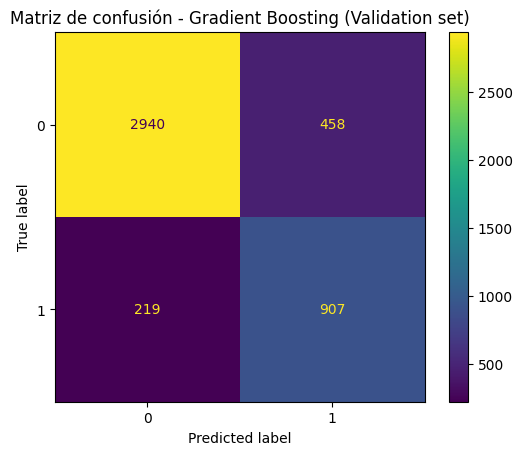

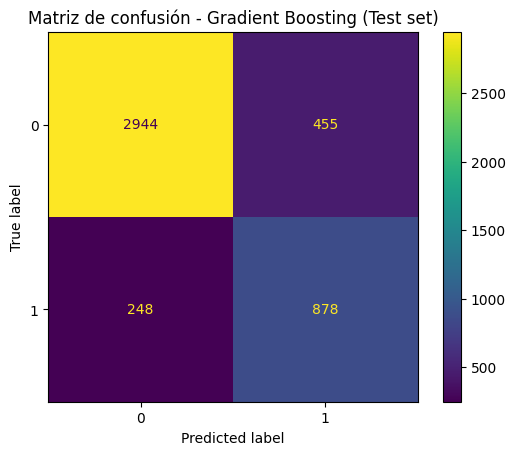

In [9]:
#Índices de las columnas numéricas y categoricas de X_train
num_cols = X_train_res.select_dtypes(include=np.number).columns
cat_cols = X_train_res.select_dtypes(exclude=np.number).columns

# Creación de preprocesamiento con ColumnTransformer y Pipelines
# Para variables numéricas → escalar
num_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

cat_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols)
    ]
)

# ============================================
# Entrenamiento y evaluación: Random Forest y Gradient Boosting
# ============================================

# 2️⃣ Definir los modelos base
rf_base = RandomForestClassifier(random_state=42)
gb_base = GradientBoostingClassifier(random_state=42)

# 3️⃣ Definir mallas de hiperparámetros
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [3, 5, 7, 9],
    'classifier__min_samples_leaf': [1, 5, 10]
}

param_grid_gb = {
    'classifier__n_estimators': [100, 200],
    'classifier__learning_rate': [0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 5, 7]
}

# 4️⃣ Pipelines
pipeline_rf = Pipeline(steps=[
    ('processor', preprocessor),
    ('classifier', rf_base),
])

pipeline_gb = Pipeline(steps=[
    ('processor', preprocessor),
    ('classifier', gb_base),
])

# 5️⃣ GridSearchCV
rf_grid = GridSearchCV(pipeline_rf, cv=3, param_grid=param_grid_rf, n_jobs=-1)
gb_grid = GridSearchCV(pipeline_gb, cv=3, param_grid=param_grid_gb, n_jobs=-1)

# 6️⃣ Entrenamiento
print("\nEntrenando Random Forest...")
rf_grid.fit(X_train_res, y_train_res)

print("\nEntrenando Gradient Boosting...")
gb_grid.fit(X_train_res, y_train_res)

# 7️⃣ Mejores hiperparámetros
print("\nMejores hiperparámetros (Random Forest):", rf_grid.best_params_)
print("Mejores hiperparámetros (Gradient Boosting):", gb_grid.best_params_)

# 8️⃣ Evaluaciones
modelos = {
    "Random Forest": rf_grid,
    "Gradient Boosting": gb_grid
}

resultados = {
    "Modelo": [],
    "Dataset": [],
    "Accuracy": [],
    "F1 Score": []
}

for nombre, modelo in modelos.items():
    for dataset, (X_split, y_split) in {
        "Train": (X_train_res, y_train_res),
        "Validation": (X_val, y_val),
        "Test": (X_test, y_test)
    }.items():
        y_pred = modelo.predict(X_split)
        acc = modelo.score(X_split, y_split)
        f1 = f1_score(y_split, y_pred, average="macro")

        resultados["Modelo"].append(nombre)
        resultados["Dataset"].append(dataset)
        resultados["Accuracy"].append(acc)
        resultados["F1 Score"].append(f1)

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)
print("\nResultados finales:")
print(df_resultados)

# 9️⃣ Matrices de confusión
for nombre, modelo in modelos.items():
    for dataset, (X_split, y_split) in {
        "Validation": (X_val, y_val),
        "Test": (X_test, y_test)
    }.items():
        y_pred = modelo.predict(X_split)
        cm = confusion_matrix(y_split, y_pred)
        disp = ConfusionMatrixDisplay(cm)
        disp.plot()
        plt.title(f"Matriz de confusión - {nombre} ({dataset} set)")
        plt.show()




## 3. Métricas de evaluación

Para evaluar el desempeño del modelo de clasificación se emplearán dos métricas principales: **Exactitud (Accuracy)** y **F1-Score**. Ambas permiten medir la capacidad del modelo para predecir correctamente el nivel de ingresos, considerando tanto la proporción de aciertos totales como el equilibrio entre precisión y sensibilidad.

* **Exactitud (Accuracy):**
  Mide la proporción de predicciones correctas sobre el total de observaciones. Es una métrica general útil para tener una visión global del rendimiento del modelo.

* **F1-Score:**
  Combina precisión y sensibilidad en una sola métrica armónica, especialmente útil cuando existen clases desbalanceadas. Un valor alto de F1 indica que el modelo mantiene un buen equilibrio entre falsos positivos y falsos negativos.

Dado que el conjunto de datos se encuentra balanceado, se considerará principalmente la **Exactitud (Accuracy)** como métrica base para la comparación entre modelos, utilizando el F1-Score como métrica complementaria de validación.

## 4. Conclusiones

Este análisis preliminar permitió identificar patrones socioeconómicos consistentes con los hallazgos de la literatura sobre predicción de ingresos. Los resultados muestran que factores como el estado civil, el nivel educativo, la edad, las horas trabajadas y la ocupación tienen una fuerte relación positiva con la probabilidad de obtener ingresos superiores a 50.000 dólares anuales. Asimismo, variables demográficas como el sexo y la raza reflejan las desigualdades estructurales del mercado laboral estadounidense, donde los hombres y las personas blancas tienden a presentar mayores niveles de ingreso. 

En contraste, atributos como el origen en ciertos países, el peso muestral del censo (fnlwgt) o la categoría de trabajos no remunerados evidencian correlaciones débiles o irrelevantes, lo que confirma su bajo aporte predictivo. Por otra parte, las correlaciones negativas asociadas a ser soltero, tener baja escolaridad, desempeñar ocupaciones poco calificadas, ser mujer o pertenecer a la población negra reafirman la persistencia de brechas sociales y económicas históricas. En conjunto, este análisis respalda la validez del modelo de predicción propuesto y orienta la selección de variables más influyentes, al tiempo que evidencia la necesidad de interpretar los resultados desde una perspectiva ética y contextual.

En la Entrega Final del presente proyecto desarrollaremos el sistema de predicciones y de recomendaciones, por tanto esta entrega simplemente se limita a un análisis preliminar. Los datos aquí contenidos y procesados serán usados para introducirlos a los modelos planeados.

